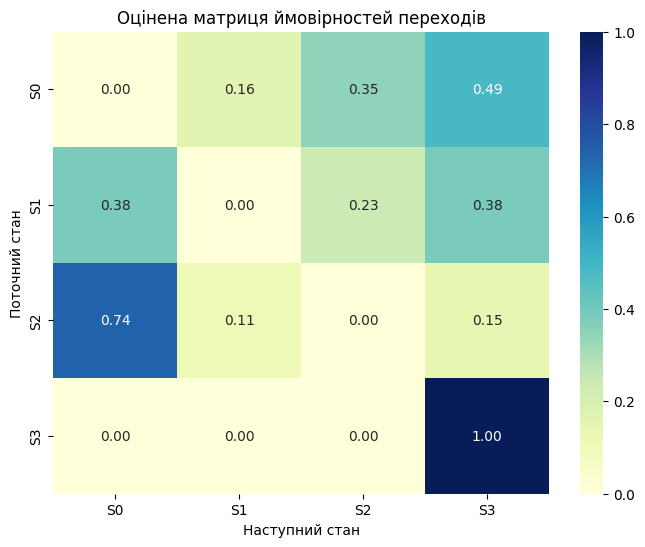

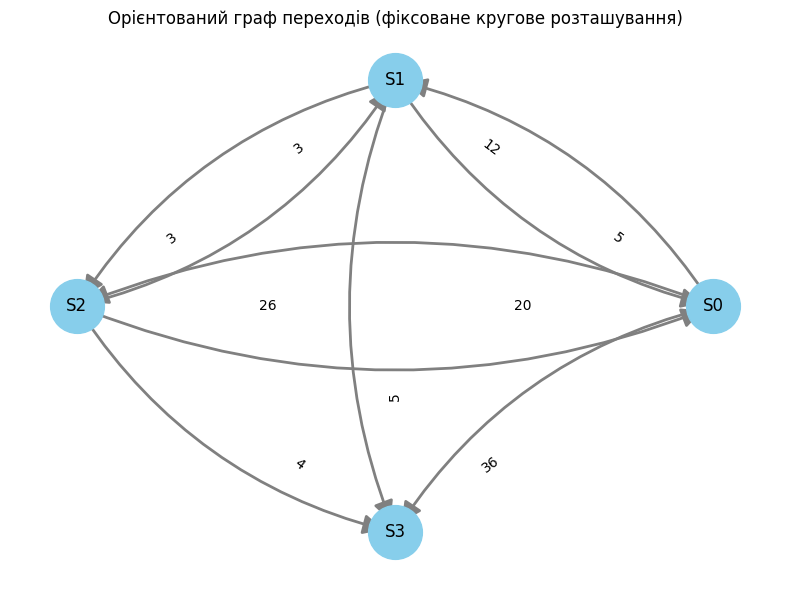

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Параметри моделювання
M = 50  # кількість суб'єктів
Tmax = 10  # максимальний час спостереження
N_states = 4  # кількість станів
state_names = [f'S{i}' for i in range(N_states)]

# Генерація випадкової матриці переходів
def generate_transition_matrix(n):
    mat = np.zeros((n, n))
    for i in range(n):
        probs = np.random.dirichlet(np.ones(n - 1))
        mat[i, :i] = probs[:i]
        mat[i, i+1:] = probs[i:]
    return pd.DataFrame(mat, index=state_names, columns=state_names)

transition_probs = generate_transition_matrix(N_states)

# Випадкові інтенсивності та розподіли
lambda_0 = {state: np.random.uniform(0.1, 1.0) for state in state_names}
lambda_type = {state: np.random.choice(['exp', 'unif']) for state in state_names}

# Наступний стан
def sample_next_state(current):
    return np.random.choice(state_names, p=transition_probs.loc[current].values)

# Час перебування
def generate_sojourn_time(current_state, Z):
    lam = lambda_0.get(current_state, 1.0)
    if lambda_type[current_state] == 'exp':
        rate = lam * np.exp(Z)
        u = np.random.uniform(0, 1)
        return -np.log(1 - u) / rate
    else:
        low = 0.5
        high = lam + np.exp(Z)
        return np.random.uniform(low, high)

# Моделювання
records = []
for m in range(M):
    t = 0
    state = state_names[0]
    Z_m = {(i, j): np.random.normal(0, 1) for i in state_names for j in state_names if j != i}

    while t < Tmax and state != state_names[-1]:
        current_state = state
        next_candidate = sample_next_state(current_state)
        Z = Z_m.get((current_state, next_candidate), 0)
        W = generate_sojourn_time(current_state, Z)

        if t + W > Tmax:
            W = Tmax - t
            censored = 0
            next_state = None
        else:
            censored = 1
            next_state = next_candidate

        records.append({
            'Subject': m,
            'Start_Time': round(t, 6),
            'From': current_state,
            'To': next_state,
            'Sojourn_Time': round(W, 6),
            'Censored': censored
        })

        t += W
        state = next_state

# DataFrame
sim_data = pd.DataFrame(records)

# --- Нова: ОЦІНОЧНА МАТРИЦЯ ПЕРЕХОДІВ ---
valid_transitions = sim_data.dropna(subset=['To'])
transition_counts = valid_transitions.groupby(['From', 'To']).size().unstack(fill_value=0)
transition_counts = transition_counts.reindex(index=state_names, columns=state_names, fill_value=0)

# Ймовірності переходів: нормалізуємо по рядках
transition_probs_est = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)
transition_probs_est.loc['S3', 'S3'] = 1.0

# Занулення діагоналі (окрім absorbing стану)
for i in range(N_states - 1):  # останній — absorbing
    transition_probs_est.iloc[i, i] = 0.0

# Виведення heatmap ймовірностей переходів
plt.figure(figsize=(8, 6))
sns.heatmap(transition_probs_est, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Оцінена матриця ймовірностей переходів")
plt.xlabel("Наступний стан")
plt.ylabel("Поточний стан")
plt.show()

# --- Створення графа ---
G = nx.DiGraph()
for (src, dst), weight in transition_counts.stack().items():
    if weight > 0:
        G.add_edge(src, dst, weight=weight)

# --- Створюємо фіксоване РОЗТАШУВАННЯ НА КОЛІ ---
def circular_layout_fixed_order(nodes):
    """
    Фіксоване розташування вузлів по колу з передбачуваним порядком.
    """
    n = len(nodes)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    return {node: (np.cos(angle), np.sin(angle)) for node, angle in zip(nodes, angles)}

# Визначаємо фіксоване колове розташування вузлів
fixed_pos = circular_layout_fixed_order(state_names)

# --- Візуалізація ---
plt.figure(figsize=(8, 6))

nx.draw_networkx_nodes(G, fixed_pos, node_size=1500, node_color='skyblue')

nx.draw_networkx_edges(
    G, fixed_pos,
    edge_color='gray',
    arrows=True,
    arrowsize=30,
    arrowstyle='-|>',
    connectionstyle='arc3,rad=0.2',
    width=2
)

nx.draw_networkx_labels(G, fixed_pos, font_size=12, font_color='black')
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, fixed_pos, edge_labels=edge_labels, font_size=10, label_pos=0.3)

plt.title("Орієнтований граф переходів (фіксоване кругове розташування)")
plt.axis('off')
plt.tight_layout()
plt.show()
